# TP - Réduction de dimensionnalité

La réduction de dimension est souvent une étape cruciale d'une pipeline de Machine Learning. Elle permet de filtrer les données, d'accélerer le traitement et bien souvent d'améliorer les performances du modèle. Des ressources sont disponibles pour en apprendre davantage :

https://www.kaggle.com/arthurtok/interactive-intro-to-dimensionality-reduction

https://www.kaggle.com/littleraj30/dimension-reduction-tutorial

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

pd.options.display.max_rows = None
pd.options.display.max_columns = None

%matplotlib inline


## Exemple 1 : Attribution de prêts bancaires

#### **Overview**

### Question 0 : 
Lire le jeu de données applications.csv dans un dataframe Pandas et afficher l'entête du dataframe

In [6]:
applications = pd.read_csv("data/applications.csv")
applications.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccompanied          Working   
1        1129500.0          Family    State servant   
2         135000.0   Unaccompanied          Working   
3         297000.0   Unaccompanied          Working   
4         513000.0   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       -9461           -637            -3648.0   
1                    0.003541      -16765          -1188            -1186.0   
2                    0.010032      -19046           -225            -4260.0   
3                    0.008019      -19005          -3039            -9833.0   
4                    0.028663      -19932          -3038            -4311.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers              1.0   
1                 1           1           0      Core staff              2.0   
2                 1           1           0        Laborers              1.0   
3                 1           0           0        Laborers              2.0   
4                 1           0           0      Core staff              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                        

## 1. Ratio de valeurs manquantes (Missing Value Ratio)

En cas de valeurs manquantes, il faut chercher d'abord à comprendre la raison de ces valeurs manquantes puis décider de les imputer ou supprimer entièrement les variables concernées.
Les variables avec beaucoup de valeurs manquantes n'apportant pas beaucoup d'information, on peut définir un seuil de données manquantes au délà duquel la variable en question sera supprimée.



### Question 1:
Afficher le pourcentage de valeurs manquantes pour chaque variable

In [7]:
(applications.isna().sum() / applications.shape[0] * 100).sort_values(ascending=False)

COMMONAREA_MEDI                 69.872297
COMMONAREA_AVG                  69.872297
COMMONAREA_MODE                 69.872297
NONLIVINGAPARTMENTS_MODE        69.432963
NONLIVINGAPARTMENTS_MEDI        69.432963
NONLIVINGAPARTMENTS_AVG         69.432963
FONDKAPREMONT_MODE              68.386172
LIVINGAPARTMENTS_MEDI           68.354953
LIVINGAPARTMENTS_MODE           68.354953
LIVINGAPARTMENTS_AVG            68.354953
FLOORSMIN_MEDI                  67.848630
FLOORSMIN_MODE                  67.848630
FLOORSMIN_AVG                   67.848630
YEARS_BUILD_MEDI                66.497784
YEARS_BUILD_AVG                 66.497784
YEARS_BUILD_MODE                66.497784
OWN_CAR_AGE                     65.990810
LANDAREA_MODE                   59.376738
LANDAREA_AVG                    59.376738
LANDAREA_MEDI                   59.376738
BASEMENTAREA_MEDI               58.515956
BASEMENTAREA_AVG                58.515956
BASEMENTAREA_MODE               58.515956
EXT_SOURCE_1                    56

### Question 2:
Supprimer les variables dont plus de 60 % des valeurs manquent.

In [8]:
na_thresh = .6
thresh = (1 - na_thresh) * applications.shape[0]
applications.dropna(axis='columns', thresh=thresh, inplace=True)

## 2. Filtre à Faible Variance (Low Variance Filter)

Les variables à faible variance n'apportent pas beaucoup d'information. Par exemple, considérons une variable dans notre ensemble de données où toutes les observations ont la même valeur, disons 1. 
Cette variable a une variance nulle et n'aura donc aucun apport dans le modèle à constuire.

### Question 3:
Imputer les valeurs manquantes avec le mode (valeur la plus représentée) des observations non manquantes. Vérifier que l'ensemble des valeurs manquantes ont été imputées.

In [9]:
value = {col: applications[col].mode()[0] for col in applications.columns}
applications.fillna(value=value, inplace=True)

In [10]:
applications.isna().sum().sum()

0

### Question 4:

Calculer la variance pour l'ensemble des variables quantitatives.

In [12]:
applications.select_dtypes(include=[np.float64, np.int64]).var().sort_values()

FLAG_MOBIL                      3.251916e-06
FLAG_DOCUMENT_12                6.503811e-06
FLAG_DOCUMENT_10                2.276297e-05
FLAG_DOCUMENT_2                 4.227326e-05
FLAG_DOCUMENT_4                 8.129156e-05
REGION_POPULATION_RELATIVE      1.913043e-04
FLAG_DOCUMENT_7                 1.918269e-04
FLAG_DOCUMENT_17                2.665869e-04
FLAG_DOCUMENT_21                3.348363e-04
FLAG_DOCUMENT_20                5.070432e-04
FLAG_DOCUMENT_19                5.947485e-04
FLAG_DOCUMENT_15                1.208253e-03
YEARS_BEGINEXPLUATATION_AVG     1.818363e-03
YEARS_BEGINEXPLUATATION_MEDI    1.859404e-03
FLAG_CONT_MOBILE                1.863122e-03
YEARS_BEGINEXPLUATATION_MODE    2.160977e-03
NONLIVINGAREA_AVG               2.365279e-03
NONLIVINGAREA_MODE              2.392764e-03
NONLIVINGAREA_MEDI              2.403850e-03
FLAG_DOCUMENT_14                2.927867e-03
FLAG_DOCUMENT_13                3.512662e-03
LANDAREA_MODE                   3.732663e-03
LANDAREA_A

### Question 5:
On remarque que la variance de plusieurs variables comme 'FLAG_MOBIL','FLAG_DOCUMENT_12','FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_2','FLAG_DOCUMENT_4' est très faible par rapport aux autres variables. Gardez uniquement les variables avec une variance supérieure ou égale à 10.

In [13]:
variances = applications.select_dtypes(include=[np.float64, np.int64]).var()
var_thresh = 10
cols_to_keep = variances[variances >= var_thresh].index
applications = applications[cols_to_keep]


## 3. Filtre à corrélation élevée (High Correlation Filter)

Une forte corrélation entre deux variables signifie qu'elles ont des tendances similaires et qu'elles sont susceptibles de véhiculer des informations similaires. Cela peut réduire considérablement les performances de certains modèles (les modèles de régression linéaire et logistique par exemple). En règle générale, il faut conserver les variables qui présentent une corrélation élevée avec la variable cible.

### Question 6:
Créer un nouveau dataframe ne contenant pas la variable dépendante (TARGET).

In [15]:
if 'TARGET' in applications.columns:
    applications.drop(columns=['TARGET'], inplace=True)

### Question 7:
Visualiser les corrélations entre les couples de variables à l'aide d'une matrice de corrélation.

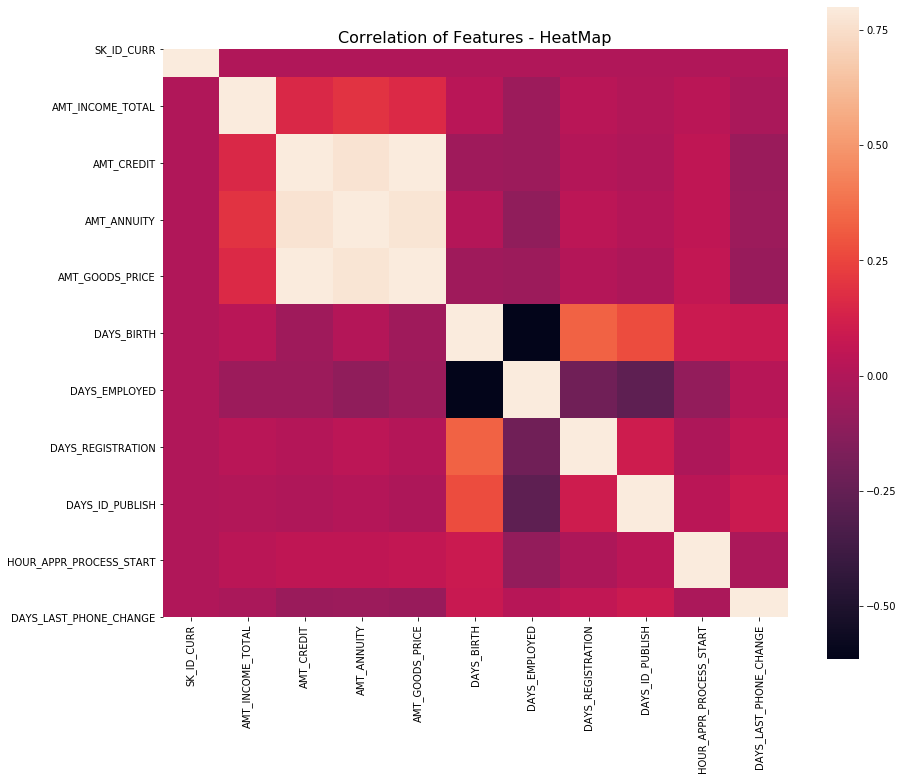

In [16]:
f , ax = plt.subplots(figsize = (14,12))
plt.title('Correlation of Features - HeatMap',y=1,size=16)
sns.heatmap(applications.corr(),square = True,  vmax=0.8)

Quelques couples de variables ont une corrélation élevée. Nous pouvons par exemple considérer de ne conserver qu'une variable parmi les variables avec une corrélation supérieure à 0.6.

## Exemple 2 : Diagnostic de cancer de sein

### Question 0 : 
Lire le jeu de données cells.csv dans un dataframe Pandas et afficher l'entête du dataframe.

In [19]:
cells = pd.read_csv('data/cells.csv')
cells.head()

id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   symmetry_mean  fractal_dimension_mean  radius_se  texture_se  perimeter_se  \
0         0.2419                 0.07871     1.0950      0.9053         8.589   
1         0.1812                 0.05667     0.5435      0.7339         3.398   
2         0.2069                 0.05999     0.7456      0.7869         4.585   
3         0.2597                 0.09744     0.4956      1.1560         3.445   
4         0.1809                 0.05883     0.7572      0.7813         5.438   

   area_se  smoothness_se  compactness_se  concavity_se  concave points_se  \
0   153.40       0.006399         0.04904       0.05373            0.01587   
1    74.08       0.005225         0.01308       0.01860            0.01340   
2    94.03       0.006150         0.04006       0.03832            0.02058   
3    27.23       0.009110         0.07458       0.05661            0.01867   
4    94.44       0.011490         0.02461       0.05688            0.01885   

   symmetry_se  fractal_dimension_se  radius_worst  texture_worst  \
0      0.03003              0.006193         25.38          17.33   
1      0.01389              0.003532         24.99          23.41   
2      0.02250              0.004571         23.57          25.53   
3      0.05963              0.009208         14.91          26.50   
4      0.01756              0.005115         22.54          16.67   

   perimeter_worst  area_worst  smoothness_worst  compactness_worst  \
0           184.60      2019.0            0.1622             0.6656   
1           158.80      1956.0            0.1238             0.1866   
2           152.50      1709.0            0.1444             0.4245   
3            98.87       567.7            0.2098             0.8663   
4           152.20      1575.0            0.1374             0.2050   

   concavity_worst  concave points_worst  symmetry_worst  \
0           0.7119                0.2654          0.4601   
1           0.2416                0.1860          0.2750   
2           0.4504                0.2430          0.3613   
3           0.6869                0.2575          0.6638   
4           0.4000                0.1625          0.2364   

   fractal_dimension_worst  Unnamed: 32  
0                  0.11890          NaN  
1                  0.08902          NaN  
2                  0.08758          NaN  
3                  0.17300          NaN  
4                  0.07678          NaN

### Question 1 : 
Supprimer les colonnes "id" ainsi que les colonnes qui vous semblent inutiles, imputer les valeurs manquantes par 0 et convertir la variable cible (diagnosis) en variable binaire.
Isoler la variable encodée dans une Serie Pandas et supprimer-là du dataframe original.

In [21]:
cells.drop(columns=['id', 'Unnamed: 32'], inplace=True)

cells.fillna(value=0, inplace=True)

cells['diagnosis'] = cells['diagnosis'].factorize()[0]

cells_diagnosis = cells['diagnosis']

cells.drop(columns=['diagnosis'], inplace=True)

### Question 2 : 
Convertir le dataframe en tableau (type arrays) puis appliquer PCA à 2 composantes.

In [23]:
cells_array = cells.values

In [37]:
pca = PCA(n_components=2, random_state=42)
pca_2d = pca.fit_transform(cells_array)

### Question 3 : 
Importer t-SNE et appliquer-là avec les paramètres suivants : n_components=2, verbose=1, perplexity=40, n_iter=2000, random_state=42

In [38]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=2000, random_state=42)
tsne_2d = tsne.fit_transform(cells_array)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 569 samples in 0.002s...
[t-SNE] Computed neighbors for 569 samples in 0.015s...
[t-SNE] Computed conditional probabilities for sample 569 / 569
[t-SNE] Mean sigma: 33.679705
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.890602
[t-SNE] KL divergence after 2000 iterations: 0.212579


### Question 3 : 
Visualiser le résultat de t-SNE et de PCA côte-à-côte en mettant la variable cible en couleur. Conclure.

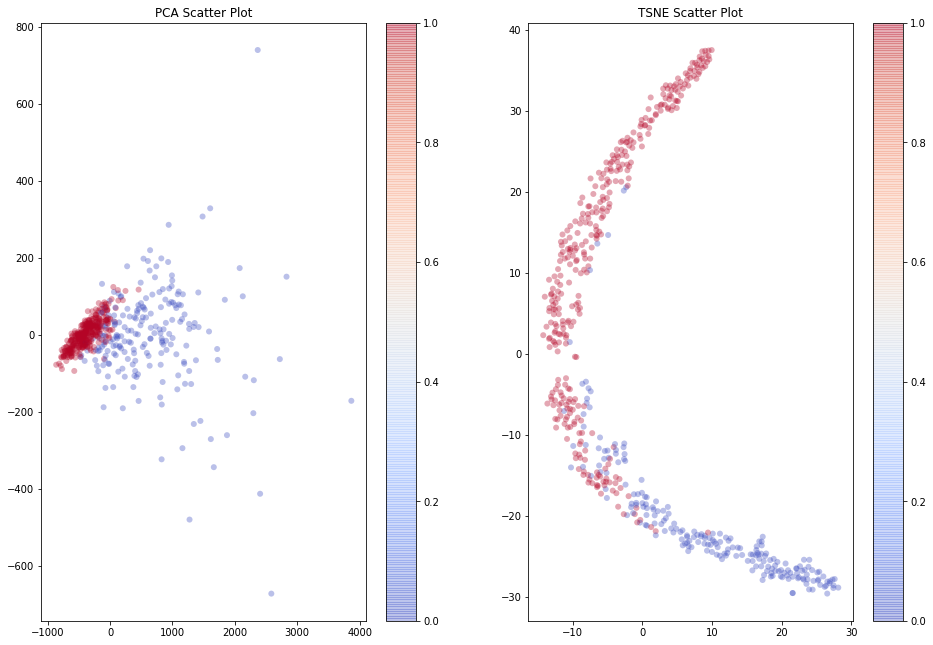

In [39]:
plt.figure(figsize = (16,11))
plt.subplot(121)
plt.scatter(pca_2d[:,0], pca_2d[:,1], c=cells_diagnosis, cmap="coolwarm", edgecolor="None", alpha=0.35)
plt.colorbar()
plt.title('PCA Scatter Plot')


plt.subplot(122)
plt.scatter(tsne_2d[:,0], tsne_2d[:,1],  c=cells_diagnosis, cmap="coolwarm", edgecolor="None", alpha=0.35)
plt.colorbar()
plt.title('TSNE Scatter Plot')

plt.show()


Essayons maintenant de standardiser les variables pour voir si nous arriverons à obtenir une meilleure séparation entre les clusters.

### Question 4 : 
Standardiser l'ensemble des variables en partant du tableau de type arrays.

In [40]:
cells_array_std = StandardScaler().fit_transform(cells_array)

### Question 5 : 
Appliquer PCA et t-SNE avec les mêmes paramètres sur le jeu de données transformé et visualiser le résultat.

In [41]:
pca = PCA(n_components=2, random_state=42)
pca_2d_std = pca.fit_transform(cells_array_std)


tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=2000, random_state=42)
tsne_2d_std = tsne.fit_transform(cells_array_std)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 569 samples in 0.001s...
[t-SNE] Computed neighbors for 569 samples in 0.037s...
[t-SNE] Computed conditional probabilities for sample 569 / 569
[t-SNE] Mean sigma: 1.522404
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.890503
[t-SNE] KL divergence after 1550 iterations: 0.888863


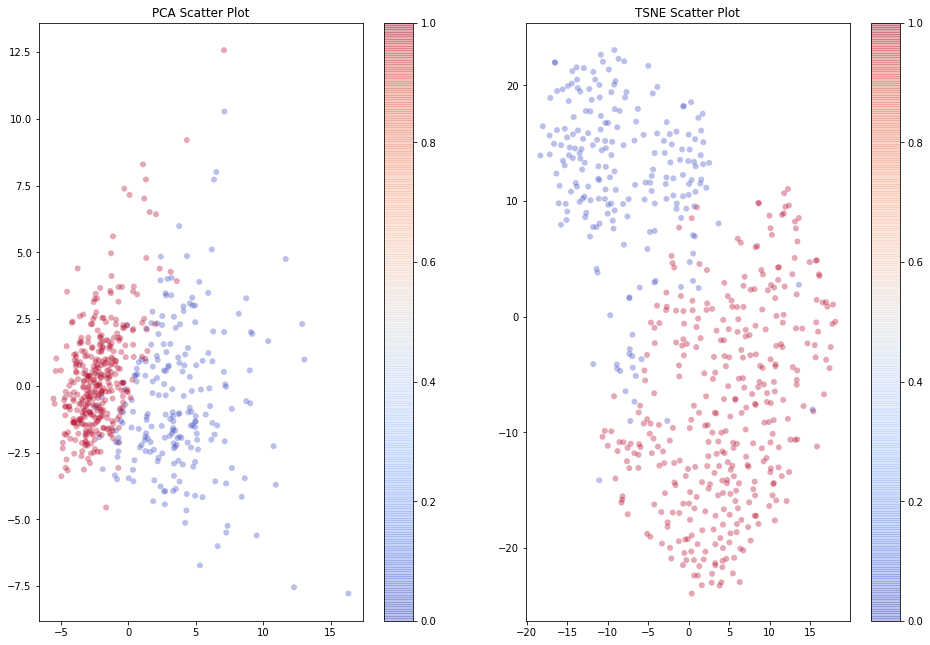

In [43]:
plt.figure(figsize = (16,11))
plt.subplot(121)
plt.scatter(pca_2d_std[:,0], pca_2d_std[:,1], c=cells_diagnosis, cmap="coolwarm", edgecolor="None", alpha=0.35)
plt.colorbar()
plt.title('PCA Scatter Plot')


plt.subplot(122)
plt.scatter(tsne_2d_std[:,0], tsne_2d_std[:,1],  c=cells_diagnosis, cmap="coolwarm", edgecolor="None", alpha=0.35)
plt.colorbar()
plt.title('TSNE Scatter Plot')

plt.show()


## Bonus

Se renseigner sur la méthode UMAP (t-SNE amélioré), et la mettre en oeuvre sur un dataset de votre choix.